# Задание по EM-алгоритму

__Предупреждение про списывание.__ Строго запрещается использовать код других студентов в своем решении. Код из открытых источников разрешается брать только фрагментами по одной строке (например, скопировать пример использования какой-то функции), нельзя копировать код по несколько строк. В случае обнаружения похожих решений выставляется 0 за __все__ задание __обоим__ студентам, чьи работы являются похожими, и подается служебная записка в деканат.

## Теоретическая часть

__Теоретическая задача (Смесь мультиномиальных распределений), 2 балла__

Пусть $X=\{x_1, \dots, x_N\}$, $x_i \in \{1, 2, 3\}$  - независимая выборка из смеси двух мультиномиальных распределений:

$$p_1: \begin{matrix}
1 & 2 & 3\\
\alpha & 1-\alpha & 0
\end{matrix}
$$

$$
p_2: \begin{matrix}
1 & 2 & 3\\
0 & 1-\beta & \beta
\end{matrix}$$

В наблюдаемой выборке $X$ содержится 30 единиц, 20 двоек и 60 троек. Проведите первую итерацию ЕМ-алгоритма разделения смеси (Е-шаг и М-шаг) из начального приближения $\alpha_0 = \beta_0 = \gamma_0 = 0.5$. 

Скрытые переменные: $Z = \{z_1, \dots, z_N\}$, $z_i = [x_i \in p_1]$ (индикатор того, что i-й объект сгенерирован из первого распределения)

Вероятностная модель:

$$p(X, Z|\alpha, \beta, \gamma) = \prod_{i=1}^N p(x_i, z_i|\alpha, \beta, \gamma) = \prod_{i=1}^N \bigl(\gamma p_1(x_i|\alpha)\bigr)^{z_i} \bigl((1-\gamma) p_2(x_i|\beta)\bigr)^{1-z_i} $$

_Подсказки:_
* На Е-шаге найдите апостериорные вероятности $q_i = q(z_i=1) = p(z_i|x_i, \alpha, \beta, \gamma)$, рассмотрите три случая $x_i=1,2,3$ и для каждого вычислите соответствующее числовое значение величины $q_i$, используя начальное приближение.
* На M-шаге решите задачу $$\mathbb{E}_{q(Z)} \log ~ p(X, Z|\alpha, \beta, \gamma) = \sum_{i=1}^N \mathbb{E}_{q(z_i)} log ~p(x_i, z_i|\alpha, \beta, \gamma) \rightarrow \max_{\alpha, \beta, \gamma} $$ Вам потребуется мат. ожидание распределения Бернулли: $\mathbb{E}_{q(z_i)} z_i = q_i$. Сумма по объектам заменится на сумму по трем случаям $x_i=1,2,3$ с учетом количества выпадений каждого номера в выборке. Чтобы выполнить максимизацию, вычислите производную по параметрам, лангранжиан использовать не нужно. В результате этого шага у вас должны получиться числовые значения параметров $\alpha, \beta, \gamma$.
* Для самопроверки можете посчитать значения $q_i$ для следующего Е-шага, у вас должны получиться такие же значения, что на предыдущем шаге, что означает, что ЕМ-алгоритм сошелся за одну итерацию.

## Практическая часть

В этом задании вам предстоит реализовать EM-алгоритм для разделения смеси многомерных гауссиан, протестировать реализацию на синтетических данных и изображениях цифр и проанализировать результаты.

### Генерация синтетических данных

Для целей отладки будем использовать синтетические данные. Сгенерируем их с помощью sklearn:

In [1]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
%matplotlib inline

Text(0,0.5,'feature 2')

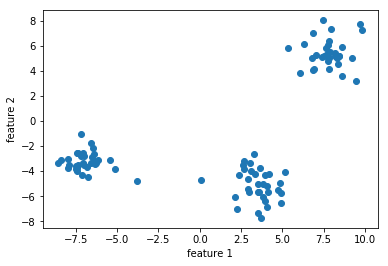

In [9]:
X, y = make_blobs()
plt.scatter(*X.T)
plt.xlabel("feature 1")
plt.ylabel("feature 2")

Если у вас сгенерировались "слипшиеся" гауссианы, перезапустите ячейку.

### Реализация EM-алгоритма для разделения смеси гауссиан

Как и при реализации многих других алгоритмов машинного обучения, нашим основным инструментом будет модуль numpy:

In [11]:
import numpy as np

__Задание 1. (5 баллов, выставляются только при наличии визуализации в следующей задаче)__ Реализуйте EM-алгоритм, следуя интерфейсу sklearn, см. прототип ниже. EM-алгоритм описан на слайде 48 в [презентации](https://github.com/ftad/BM2020/blob/master/materials/presentation_EM_ftad.pdf).

* Один из шагов EM-алгоритма разделения смеси включает подсчет матрицы ковариации. С этим поможет функция [np.cov](https://numpy.org/doc/stable/reference/generated/numpy.cov.html), пример использования дан ниже. Посмотрите документацию функции и обратите внимание на параметр, позволяющий задавать веса объектов!
* Один из шагов EM-алгоритма включает подсчет плотности многомерного нормального распределения. С этим поможет функция [scipy.stats.multivariate_normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html).
* Чтобы избежать ошибки Singular matrix, сообщающей, что у какой-то гауссианы получилась вырожденная матрица ковариации, прибавляйте к вычисляемым матрицам ковариации единичную матрицу, умноженную на небольшой коэффициент (cov_reg в реализации).

Вов всех заданиях ниже рекомендуется использовать гиперпараметры, заданные по умолчанию, если не указано иное.

In [ ]:
# example with np.cov
np.cov(X, rowvar=False)

In [ ]:
from scipy.stats import multivariate_normal
from sklearn.base import BaseEstimator

class GMM(BaseEstimator):
    def __init__(self, num_clusters=3, num_iters=100, cov_reg=1e-6):
        self.num_clusters = num_clusters
        self.num_iters = num_iters
        self.cov_reg = cov_reg
        
    def fit_transform(self, X):
        """
        * input: data matrix X, shape: [num_objects, num_features]
        
        The method runs EM-algorithm to fit 
        a mixture of multinomial Gaussians on data.
        At the end of running, the following atributes should be learned:
        * self.mu: Gaussians' means, shape: [num_clusters, num_features]
        * self.sigma: Gaussians' covariance matrices, 
                      shape: [num_clusters, num_features, num_features]
        * self.pi: prior misture weights, shape: [num_clusters]
                   self.pi should sum to 1
        The code for attribute initialization is given below
        
        The method returns:
        * y: posterior distribution over Gaussians for each objects,
             shape: [num_objects, num_clusters]
        """
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.mu = 2*np.random.rand(self.num_clusters, self.d) - 1
        self.sigma = np.concatenate([np.eye(self.d)[None, :, :] \
                     for k in range(self.num_clusters)], axis=0)
        self.pi = np.random.rand(self.num_clusters)
        self.pi /= self.pi.sum()
        
        ### your code below ###
        

### Тестирование EM-алгоритма на синтетических данных

__Задание 2 (0.5 балла, включая вопрос ниже).__ Протестируйте вашу реализацию на синтетических данных, сгенерированных выше в ноутбуке: запустите алгоритм на данных X с числом гауссиан, равным 3, __визуализируйте__, к какому кластеру отнесен каждый объект (получится трехцветный scatter-plot в осях двух признаков), а также __визуализируйте__ средние обученных гауссиан (на этом же графике). Чтобы определить принадлежность объекта к кластеру, используйте максимум апостериорной вероятности. Для получения хорошего результата может понадобиться перезапустить EM-алгоритм из другой начальной инициализации.

In [ ]:
### your code here


__Вопрос:__ получились ли матрицы ковариации, близкие к тем, которые использовались при генерации случайных данных?

__Ответ:__ 

In [ ]:
### your code here (for question)


EM-алгоритм выполняет "мягкую" кластеризацию: для каждого объекта определяется, с какой вероятностью он принадлежит к каждому из кластеров, вместо того, чтобы выбирать один кластер ("жесткая" кластеризация). Чтобы иллюстрировать это свойство, используем EM-алгоритм для разделения двух близко расположенных гауссиан. Сгенерируем такие данные:

Text(0,0.5,'feature 2')

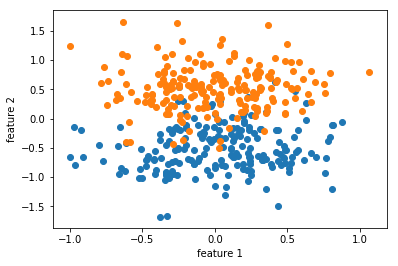

In [12]:
X0 = np.random.multivariate_normal([0, -0.5], 0.15*np.eye(2), size=200)
X1 = np.random.multivariate_normal([0, 0.5], 0.15*np.eye(2), size=200)
X2 = np.vstack([X0, X1])
plt.scatter(*X0.T)
plt.scatter(*X1.T)
plt.xlabel("feature 1")
plt.ylabel("feature 2")

__Задание 3 (0.5 балла).__ Обучите вашу реализацию EM-алгоритма с числом гауссиан, равным 2, на сгенерированных данных. Сделайте __две__ визуализации: одна для жесткой кластеризации (цвета показывают, к какому кластеру отнесен каждый объект - аналогично предыдущей визуализации) и одна для мягкой кластеризации (цвета показывают апостериорную вероятность первой гауссианы). __Сделайте выводы из этих визуализаций.__ Для получения хорошего результата может понадобиться перезапустить EM-алгоритм из другой начальной инициализации.

In [ ]:
### your code here


__Ваш вывод:__ 

### Тестирование EM-алгоритма на данных с изображениями

Теперь протестируем реализацию на данных изображений цифр. Будем использовать стандартный набор данных digits. Нормируем данные (для численной устойчивости) и обрежем рамку толщиной один пиксель (также для численной устойчивости).

In [ ]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

In [ ]:
digits = load_digits()
X_dig = digits["data"]
y_dig = digits["target"]
X_dig.shape

In [ ]:
scaler = StandardScaler()
X_dig_sc = scaler.fit_transform(X_dig)

In [ ]:
X_dig_cr = X_dig_sc.reshape(-1, 8, 8)[:, 1:-1, 1:-1].\
                    reshape(X_dig_sc.shape[0], -1)

__Задание 4 (каждый пункт 1 балл).__ Примените EM-алгоритм к данным, использовав число гауссиан, равное 10. 
1. Изобразите средние всех десяти гауссиан в виде изображений 6x6, подписав (в plt.title) номер гауссианы. Напечатайте, к какому кластеру отнесены первые 10 объектов выборки. Напечатайте их классы согласно данным. Можно ли сказать, что какие-то кластеры соответствуют конкретным цифрам? Какие? Приветствуется другой анализ визуализации. Может потребоваться перезапустить EM-алгоритм.
2. Найдите несколько объектов (>=3), у которых максимальная апостериорная вероятность меньше 0.9. Визуализируйте эти объекты в виде изображений 6x6, определите для них две наибольшие предсказанные апостериорные вероятности. Можно ли проинтерпретировать, почему эти объекты находятся на "границе" кластеров? Как? Чтобы найти >=3 объектов, удовлетворяющих условию, может потребоваться перезапустить EM-алгоритм. В этом случае сделайте отдельную визуализацию средних гауссиан для нового запуска.

In [ ]:
# your code here


__Выводы к пункту 1:__ 

In [ ]:
### your code here


__Выводы к пункту 2:__ 